### **Retinal Vessel Segmentation** 
Name: Synvi Alfajrine Loeba Bistomy

NIM: 19/446477/TK/49582

Retinal fundus imaging is useful for the diagnosis, screening, and screening of cardiovascular and ophthalmic diseases, including age-related macular degeneration (AMD), diabetic retinopathy (DR), glaucoma, hypertension, atherosclerosis, and choroidal neovascularization, where AMD and DR are believed to be the two main causes of blindness [1]. \

Vessel segmentation is one of approaches for analyzing retinal fundus images. The segmented vascular tree can be used to extract the morphological attributes of blood vessels, such as length, width, branching and angles [1]. \

Manual segmentation of the vascular tree in retinal images is a tedious task that requires experience and skill. Additionally, it has time-consuming process. In this assignment, retinal blood vessel segmentation is done using morphological operators.

In [71]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [72]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import skimage
from skimage import data
from skimage import filters
import time
from skimage import io, morphology
from PIL import Image
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, auc

### Dataset

Dataset used in this assigment is taken from DRIVE dataset, that can be retrieved from this [link](https://drive.grand-challenge.org/DRIVE/). It
is an openly available dataset consisting of 40 images of size 565 × 584 pixels.

Image 21 will be segmented first.

In [73]:
path_train_images = '/content/drive/MyDrive/datasets/training/images/'       
path_groundtruth = '/content/drive/MyDrive/datasets/training/1st_manual/'

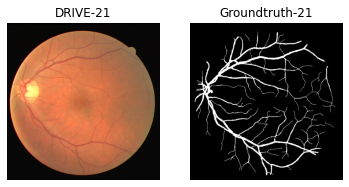

In [75]:
path = '/content/drive/MyDrive/datasets/training/images/21_training.tif' #retinal image-21
image = cv.imread(path, -1)
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

path_truth = '/content/drive/MyDrive/datasets/training/1st_manual/21_manual1.gif' #groundtruth for vessel segmentation 21
truth = Image.open(path_truth)
truth = np.array(truth, dtype=np.uint8)

plt.figure()
plt.subplot(1, 2, 1)
plt.title("DRIVE-"+str(21))
plt.axis('off')
plt.imshow(image)

plt.subplot(1, 2, 2)
plt.title("Groundtruth-"+str(21))
plt.axis('off')
plt.imshow(truth, cmap='gray')

In [76]:
image.shape

(584, 565, 3)

### Extract Green Channel

Color fundus images contain red, green, and blue channels. Since the green channel have the best contrast for vessel image, the green channel is seleceted for this segmentation.

In [77]:
r,img_g,b = cv.split(image)

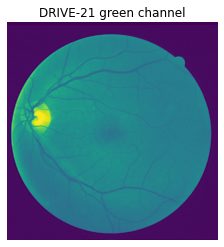

In [78]:
plt.title("DRIVE-"+str(21)+" green channel")
plt.axis('off')
plt.imshow(img_g)

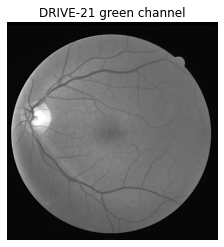

In [79]:
plt.title("DRIVE-"+str(21)+" green channel")
plt.axis('off')
plt.imshow(img_g, cmap='gray')

### CLAHE
(CLAHE) was applied to the green
channel image 
CLAHE (Contrast Limited Adaptive Histogram Equalization) is applied to increase the contrast of vessel image.

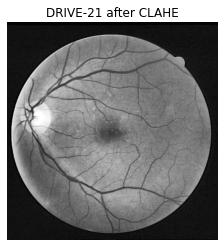

In [112]:
clahe = cv.createCLAHE(clipLimit=3.0, tileGridSize=(3,3))
img_cl = clahe.apply(img_g)

plt.title("DRIVE-"+str(21)+" after CLAHE")
plt.axis('off')
plt.imshow(img_cl, cmap='gray')

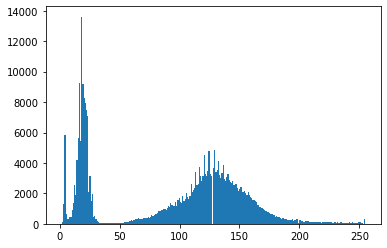

In [113]:
fig=plt.figure();
plt.hist(img_cl.flatten(), 256)
fig.show();

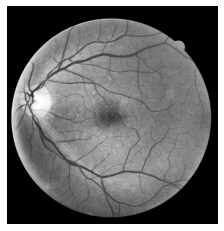

In [114]:
img_cl[img_cl<=40] = 0
plt.axis('off')
plt.imshow(img_cl, cmap='gray')

To decrease salt and pepper noise, median filter is applied to enhanced image.

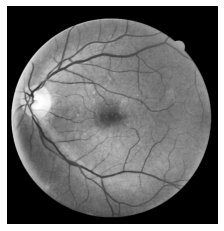

In [115]:
img_cl1 = cv.medianBlur(img_cl,3)
plt.axis('off')
plt.imshow(img_cl1, cmap='gray')

### Estimating background
To get the object we wanted, the enhaced image needs to be substracted by the background. To get the background, morphology operation is applied to the image.

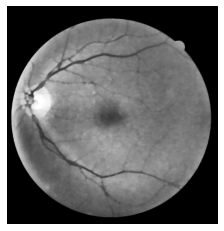

In [116]:
img_bg1 = cv.morphologyEx(img_cl, cv.MORPH_OPEN, cv.getStructuringElement(cv.MORPH_ELLIPSE,(5,5)), iterations = 1)
img_bg2 = cv.morphologyEx(img_bg1, cv.MORPH_CLOSE, cv.getStructuringElement(cv.MORPH_ELLIPSE,(5,5)), iterations = 1)
plt.axis('off')
plt.imshow(img_bg2, cmap='gray')

Here is the resulting image after substracted by the estimated background.

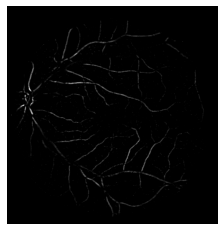

In [117]:
img_sub = cv.subtract(img_bg2, img_cl1)
plt.axis('off')
plt.imshow(img_sub, cmap='gray')

Constrast is then incereased using CLAHE, to get clearer vessels. 

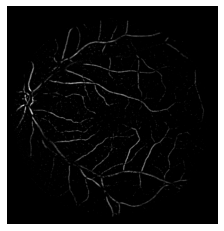

In [118]:
clahe2 = cv.createCLAHE(clipLimit=20.0, tileGridSize=(3,3))
img_cl2 = clahe2.apply(img_sub)

plt.axis('off')
plt.imshow(img_cl2, cmap='gray')

In [119]:
np.mean(img_cl2)

22.6112074190811

### Output Image
Thresholding was done based on the average intensity value of image. After segmented, image is passed through median filter to reduce noises. The resulting image can be seen still has noises even after filtered. 

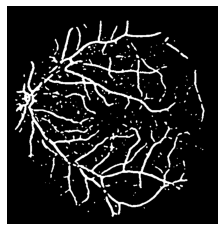

In [121]:
img_med = cv.medianBlur(cv.GaussianBlur(img_cl2,(3,3),0), 3)
ret,img_out = cv.threshold(img_med,np.mean(img_cl2),255, cv.THRESH_BINARY)
img_out = cv.medianBlur(img_out, 5)

plt.axis('off')
plt.imshow(img_out, cmap='gray')

### Performance Evaluation

In [144]:
def calc_cmat(mat):
  tn, fp, fn, tp = mat[0], mat[1], mat[2], mat[3]
  print("TP: ",tp," | FP: ",fp," | FN: ",fn," | TN: ",tn)
  acc = (tp+tn)/(tp+fn+fp+tn)
  spec = tn/(tn+fp)
  sens = tp/(tp+fn)
  f1s = 2*tp/(2*tp+fp+fn)

  return acc, spec, sens, f1s, tp, fp

In [145]:
unique, counts = np.unique(truth, return_counts=True)
stack = np.hstack([img_out, truth])

mat = confusion_matrix(truth.flatten(), img_out.flatten())
acc, sp, sn, f1, tp, fp = calc_cmat(mat.flatten())

print(" ")
print("Results of vessel segmentation on the image 21 of DRIVE dataset")
print("Accuracy   : ", acc*100)
print("Specificity: ", sp*100)
print("Sensitivity: ", sn*100)
print("F1 Score   : ", f1*100)

TP:  17345  | FP:  9306  | FN:  8539  | TN:  294770
 
Results of vessel segmentation on the image 21 of DRIVE dataset
Accuracy   :  94.59176869923627
Specificity:  96.93958089425013
Sensitivity:  67.01050842219132
F1 Score   :  66.03216903017037


The method used for retinal vessel segmentation have relatively good performance on accuracy and specificity on image 21. Since the segmentation can differentiate the vessel and the background correctly. The sensitivity is a bit low, since the method can not optimally classify all the vessel pixels. 

To increase the performance of the segmentation, we must find a solution to reduce the noise on the output image without losing too much vessel pixel.

### Applying the segmentation method above to multiple DRIVE images (Image 21-image 31)

Image Number:  21
TP:  18625  | FP:  15345  | FN:  6033  | TN:  289957
Segmentation performance image 21
Accuracy   :  93.52103285246697
Specificity:  94.97382919207867
Sensitivity:  75.53329548219645
F1 Score   :  63.53619430988606
 
Image Number:  22
TP:  23775  | FP:  14551  | FN:  6034  | TN:  285600
Segmentation performance image 22
Accuracy   :  93.76136501394109
Specificity:  95.1521067729243
Sensitivity:  79.75779127109263
F1 Score   :  69.78792103911353
 
Image Number:  23
TP:  19183  | FP:  48155  | FN:  2540  | TN:  260082
Segmentation performance image 23
Accuracy   :  84.63601648684688
Specificity:  84.37728111810068
Sensitivity:  88.30732403443355
F1 Score   :  43.07833956501724
 
Image Number:  24
TP:  28126  | FP:  14306  | FN:  10103  | TN:  277425
Segmentation performance image 24
Accuracy   :  92.60243665898898
Specificity:  95.09616735965668
Sensitivity:  73.57241884433283
F1 Score   :  69.73878330295929
 
Image Number:  25
TP:  18534  | FP:  6108  | FN:  13135  | T

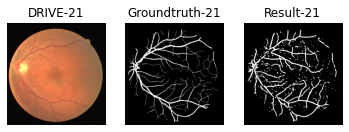

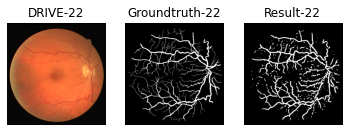

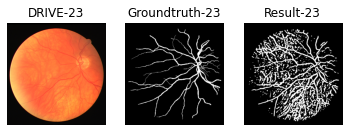

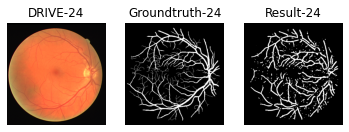

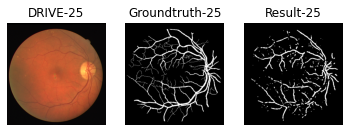

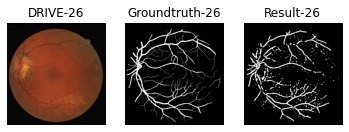

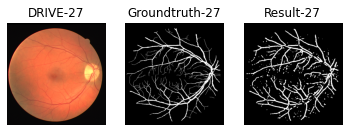

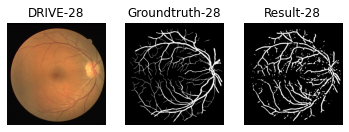

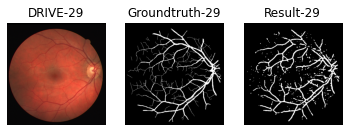

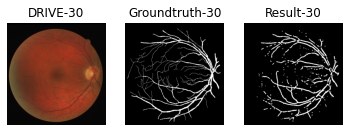

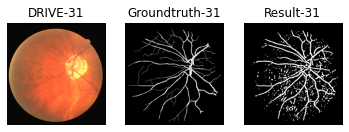

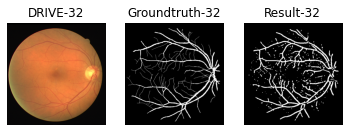

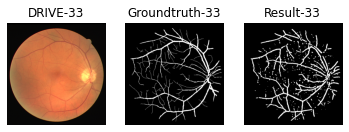

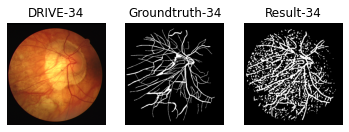

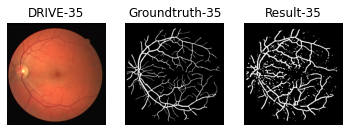

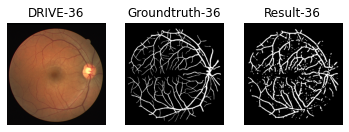

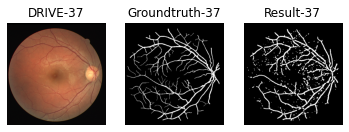

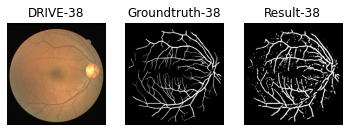

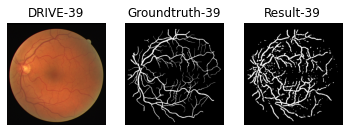

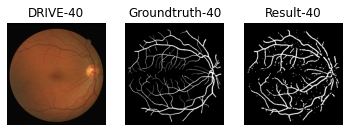

In [149]:
acc = []
spcf = []
sens = []
f1_sc = []

for num in range(21,41):
  #Original image
  path = path_train_images
  name = str(num)+'_training.tif'                                  
  path_img = path + name
  image = cv.imread(path_img, -1)
  image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
  print("Image Number: ", num)

  r,image_g,b = cv.split(image)
  
  clahe = cv.createCLAHE(clipLimit=3.0, tileGridSize=(3,3))
  image_cl = clahe.apply(image_g)
  
  image_cl[image_cl<=40] = 0
  image_cl1 = cv.medianBlur(image_cl,3)
 
  #Estimating Background
  bg1 = cv.morphologyEx(image_cl, cv.MORPH_OPEN, cv.getStructuringElement(cv.MORPH_ELLIPSE,(5,5)), iterations = 1)
  bg2 = cv.morphologyEx(bg1, cv.MORPH_CLOSE, cv.getStructuringElement(cv.MORPH_ELLIPSE,(5,5)), iterations = 1)


  sub = cv.subtract(bg2, image_cl1)

  clahe2 = cv.createCLAHE(clipLimit=20.0, tileGridSize=(3,3))
  image_cl2 = clahe2.apply(sub)

  median = cv.medianBlur(cv.GaussianBlur(image_cl2,(3,3),0), 3)

  median = cv.medianBlur(cv.GaussianBlur(image_cl2,(3,3),0), 3)
  ret,image_out = cv.threshold(median,np.mean(img_cl2),255, cv.THRESH_BINARY)
  image_out = cv.medianBlur(image_out, 5) # Segmentation result


  #Groundtruth
  path = path_groundtruth
  name = str(num)+'_manual1.gif'
  path_truth = path + name
  truth_gif = Image.open(path_truth)
  truth_gif = np.array(truth_gif, dtype=np.uint8)

  #Performance Evaluation
  unique, counts = np.unique(truth_gif, return_counts=True)
  stack = np.hstack([image_out, truth_gif])

  matrix = confusion_matrix(truth_gif.flatten(), image_out.flatten())
  a, sp, sn, f1, tp, fp = calc_cmat(matrix.flatten())

  acc.append(a*100)
  spcf.append(sp*100)
  sens.append(sn*100)
  f1_sc.append(f1*100)

  print("Segmentation performance image "+str(num))
  print("Accuracy   : ", a*100)
  print("Specificity: ", sp*100)
  print("Sensitivity: ", sn*100)
  print("F1 Score   : ", f1*100)
  
  print(" ")
  plt.figure()
  plt.subplot(1, 3, 1)
  plt.title("DRIVE-"+str(num))
  plt.axis('off')
  plt.imshow(image)
  
  plt.subplot(1, 3, 2)
  plt.title("Groundtruth-"+str(num))
  plt.axis('off')
  plt.imshow(truth_gif, cmap='gray')
  
  plt.subplot(1, 3, 3)
  plt.title("Result-"+str(num))
  plt.axis('off')
  plt.imshow(image_out, cmap='gray')

### Average Performance of All DRIVE Dataset 

In [155]:
print("Accuracy = \t", sum(acc)/len(acc))
print("Specificity = \t", sum(spcf)/len(spcf))
print("Sensitivity = \t", sum(sens)/len(sens))
print("F1 Score = \t", sum(f1_sc)/len(f1_sc))
print(" ")

Accuracy = 	 92.74210510364892
Specificity = 	 94.30718771798416
Sensitivity = 	 76.64419658324289
F1 Score = 	 65.02933357773861
 


From the result above, the segmentation method have good accuracy, specificity, mediocre sensitivity, and low F1 Score.

In [154]:
average = (np.add(np.add(np.add(acc, spcf), sens),f1_sc))/4

print("Best Segmentation", np.where(average == max(average)))
print("Worst Segmentation", np.where(average == min(average)))

Best Segmentation (array([1]),)
Worst Segmentation (array([2]),)


The best and worst segmentation result are Image 21 and Image 22.

### Conclusion
Segmentation steps applied to DRIVE dataset in this assignment:

1.   Extracting green channel from RGB image
2.   Applying CLAHE to green channel image
3. Estimating background using morphology operation
4. Substracting image to its estimated background
5. Applying CLAHE and median filter to the substracted image to get the vessel segmentation.

The approach applied to segment retinal vessel has high accuracy and specificity but still needs improvement to get better result. The segmented images have noises and the vessel pixels can not be detected thoroughly. There are some vessel pixels that loses in the segmentation process. 

### References:


1.   Q. Li, B. Feng, L. Xie, P. Liang, H. Zhang and T. Wang, "A Cross-Modality Learning Approach for Vessel Segmentation in Retinal Images," in IEEE Transactions on Medical Imaging, vol. 35, no. 1, pp. 109-118, Jan. 2016, doi: 10.1109/TMI.2015.2457891.
2.   Özkaya, Umut & Öztürk, Şaban & Akdemir, Bayram & Seyfi, Levent, "An Efficient Retinal Blood Vessel Segmentation using Morphological Operations", 2018, pp. 1-7, 10.1109/ISMSIT.2018.8567239. 
3. Digital Retinal Images for Vessel Extraction (DRIVE). Available at https://drive.grand-challenge.org/DRIVE/